##Import Libraries

In [52]:
import pickle
import gzip
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

##Load Dataset

In [53]:
def read_pickle_data(file_name):
    f = gzip.open(file_name, 'rb')
    data = pickle.load(f, encoding='latin1')
    f.close()
    return data

In [54]:
data_set = read_pickle_data('/content/drive/MyDrive/Colab Notebooks/ML Projects/Sign Language Detection/asl_alphabet.pkl.gz')

In [55]:
type(data_set)

list

In [56]:
len(data_set)

87000

##Custom Dataloader

In [57]:
class CustomDataset(Dataset):

    def __init__(self, X_Train, Y_Train, transform=None):
        self.X_Train = X_Train
        self.Y_Train = Y_Train
        self.transform = transform

    def __len__(self):
        return len(self.X_Train)

    def __getitem__(self, idx):
      
      # if torch.is_tensor(idx):
      #   idx = idx.tolist()
      x = torch.tensor(self.X_Train[idx], dtype=torch.float32)
      y = torch.tensor(self.Y_Train[idx], dtype=torch.long)

      if self.transform:
          x = self.transform(x)
          y = self.transform(y)

      return x, y
      # return idx

In [58]:
X_train = [] 
y_train = []

X_val = []
y_val = []

X_test = []
y_test = []


train_ds, val_ds, test_ds = random_split(data_set,[69600,8700,8700])
# train_ds, val_ds, test_ds = random_split(data_set,[24000,3000,3000])
for features,label in train_ds:
    X_train.append(features)
    y_train.append(label)

for features,label in val_ds:
    X_val.append(features)
    y_val.append(label)

for features,label in test_ds:
    X_test.append(features)
    y_test.append(label)

In [59]:
batch_size = 128

In [60]:
tf = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])

In [61]:
dataset_train = CustomDataset(X_train, y_train, transform=None)

ds_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=False, num_workers=0)

In [62]:
dataset_val = CustomDataset(X_val, y_val, transform=None)

ds_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False, num_workers=0)

In [63]:
dataset_test = CustomDataset(X_test, y_test, transform=None)

ds_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=0)

Number =  7
torch.Size([1, 100, 100])


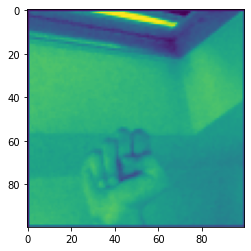

In [64]:
for i, (images, labels) in enumerate(ds_train):
  if(i>0):
    break
  plt.imshow(images[1][0])
  print("Number = ",int(labels[0]))
  print(images[1].shape)

##Create CNN Model

In [65]:
"""
image pixels = 100*100
after padding = (100+4) * (100+4)   = 104*104
after conv =  (104-5+1) * (104-5+1)  * 6  = 100*100   * 6  
after pooling = (100/2)  * (100/2) * 6    = 50*50   * 6

after 2d conv = (50-5+1)  * (50-5+1)  * 16    =   46*46*16
after 2nd pooling  = (46/2) * (46/2)  * 16    =   23*23*16

after 3rd pooling  = (23-1) * (23-1)  * 16    =   22*22*16


after flattening  =  7744 
"""

'\nimage pixels = 100*100\nafter padding = (100+4) * (100+4)   = 104*104\nafter conv =  (104-5+1) * (104-5+1)  * 6  = 100*100   * 6  \nafter pooling = (100/2)  * (100/2) * 6    = 50*50   * 6\n\nafter 2d conv = (50-5+1)  * (50-5+1)  * 16    =   46*46*16\nafter 2nd pooling  = (46/2) * (46/2)  * 16    =   23*23*16\n\nafter 3rd pooling  = (23-1) * (23-1)  * 16    =   22*22*16\n\n\nafter flattening  =  7744 \n'

In [66]:
# check device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [67]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
                          # First Convolution Layer
                          nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = 5, padding = 2),       #Padding will add extra pixels like photo frame
                          nn.MaxPool2d(kernel_size = 2, stride = 2),
                          nn.ReLU(),

                          # Second Convolution Layer 
                          nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5, padding = 0),
                          nn.MaxPool2d(kernel_size = 2, stride = 2),
                          nn.ReLU(),

                          nn.Dropout(p = 0.2),
                          nn.MaxPool2d(kernel_size = 2, stride = 1),

                          nn.Flatten(),

                          nn.Linear(in_features = 7744, out_features = 120),
                          nn.ReLU(),
                          nn.Linear(in_features = 120, out_features = 84),
                          nn.ReLU(),
                          nn.Linear(in_features = 84, out_features = 29),
                          )

  def forward(self, batch):
    return self.model(batch)


In [68]:
model = CNN()
model.to(device)

CNN(
  (model): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=7744, out_features=120, bias=True)
    (10): ReLU()
    (11): Linear(in_features=120, out_features=84, bias=True)
    (12): ReLU()
    (13): Linear(in_features=84, out_features=29, bias=True)
  )
)

In [75]:
def train_model(train_data, val_data, model, lr=0.01, momentum=0.9, nesterov=False, n_epochs=30):
  """Train a model for N epochs given data and hyper-params."""
  # We optimize with SGD
  # optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, nesterov=nesterov)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  for epoch in range(1, 11):
      print("-------------\nEpoch {}:\n".format(epoch))


      # Run **training***
      loss, acc = run_epoch(train_data, model.train(), optimizer)
      print('Train loss: {:.6f} | Train accuracy: {:.6f}'.format(loss, acc))

      # Run **validation**
      val_loss, val_acc = run_epoch(val_data, model.eval(), optimizer)
      print('Val loss:   {:.6f} | Val accuracy:   {:.6f}'.format(val_loss, val_acc))
      # Save model
      torch.save(model, 'mnist_model_fully_connected.pt')
  return val_acc

In [93]:
def run_epoch(data, model, optimizer):
    """Train model for one pass of train data, and return loss, acccuracy"""
    # Gather losses
    losses = []
    batch_accuracies = []

    # If model is in train mode, use optimizer.
    is_training = model.training

    # Iterate through batches
    for batch in tqdm(data):
        # Grab x and y
        
        x, y = batch
        x, y = x.to(device), y.to(device)
        
        # Get output predictions
        out = model(x)

        # Predict and store accuracy
        predictions = torch.argmax(out, dim=1)
        batch_accuracies.append(compute_accuracy(predictions, y))

        # Compute loss
        # loss = F.cross_entropy(out, y)
        # losses.append(loss.data.item())

        cec = nn.CrossEntropyLoss()
        loss = cec(out,y)
        losses.append(loss.data.cpu())
        

        # If training, do an update.
        if is_training:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Calculate epoch level scores
    avg_loss = np.mean(losses)
    avg_accuracy = np.mean(batch_accuracies)
    return avg_loss, avg_accuracy

In [71]:
def compute_accuracy(predictions, y):
    """Computes the accuracy of predictions against the gold labels, y."""
    return np.mean(np.equal(predictions.cpu().numpy(), y.cpu().numpy()))

In [94]:
lr=0.1
momentum=0
train_model(ds_train, ds_val, model, lr=lr, momentum=momentum)

-------------
Epoch 1:



100%|██████████| 544/544 [00:06<00:00, 83.19it/s]


Train loss: 3.378562 | Train accuracy: 0.035190


100%|██████████| 68/68 [00:00<00:00, 128.57it/s]


Val loss:   3.376263 | Val accuracy:   0.039896
-------------
Epoch 2:



100%|██████████| 544/544 [00:06<00:00, 87.37it/s]


Train loss: 3.378265 | Train accuracy: 0.034773


100%|██████████| 68/68 [00:00<00:00, 133.03it/s]


Val loss:   3.376261 | Val accuracy:   0.039896
-------------
Epoch 3:



100%|██████████| 544/544 [00:06<00:00, 88.09it/s]


Train loss: 3.378267 | Train accuracy: 0.034773


100%|██████████| 68/68 [00:00<00:00, 127.94it/s]


Val loss:   3.376261 | Val accuracy:   0.039896
-------------
Epoch 4:



100%|██████████| 544/544 [00:06<00:00, 88.35it/s]


Train loss: 3.378267 | Train accuracy: 0.034802


100%|██████████| 68/68 [00:00<00:00, 132.63it/s]


Val loss:   3.376261 | Val accuracy:   0.039896
-------------
Epoch 5:



100%|██████████| 544/544 [00:06<00:00, 88.67it/s]


Train loss: 3.378267 | Train accuracy: 0.034802


100%|██████████| 68/68 [00:00<00:00, 106.40it/s]


Val loss:   3.376261 | Val accuracy:   0.039896
-------------
Epoch 6:



100%|██████████| 544/544 [00:06<00:00, 86.30it/s]


Train loss: 3.378267 | Train accuracy: 0.034802


100%|██████████| 68/68 [00:00<00:00, 131.64it/s]


Val loss:   3.376261 | Val accuracy:   0.039896
-------------
Epoch 7:



100%|██████████| 544/544 [00:06<00:00, 90.42it/s]


Train loss: 3.378268 | Train accuracy: 0.034802


100%|██████████| 68/68 [00:00<00:00, 131.54it/s]


Val loss:   3.376261 | Val accuracy:   0.039896
-------------
Epoch 8:



100%|██████████| 544/544 [00:05<00:00, 90.84it/s]


Train loss: 3.378268 | Train accuracy: 0.034802


100%|██████████| 68/68 [00:00<00:00, 133.65it/s]


Val loss:   3.376261 | Val accuracy:   0.039896
-------------
Epoch 9:



100%|██████████| 544/544 [00:05<00:00, 91.06it/s]


Train loss: 3.378268 | Train accuracy: 0.034845


100%|██████████| 68/68 [00:00<00:00, 132.30it/s]


Val loss:   3.376261 | Val accuracy:   0.039896
-------------
Epoch 10:



100%|██████████| 544/544 [00:05<00:00, 91.48it/s]


Train loss: 3.378268 | Train accuracy: 0.034845


100%|██████████| 68/68 [00:00<00:00, 130.98it/s]


Val loss:   3.376261 | Val accuracy:   0.039896


0.039896376897533205

In [95]:
lr=0.001
momentum=0
train_model(ds_train, ds_val, model, lr=lr, momentum=momentum)

-------------
Epoch 1:



100%|██████████| 544/544 [00:06<00:00, 84.96it/s]


Train loss: 3.372267 | Train accuracy: 0.033969


100%|██████████| 68/68 [00:00<00:00, 131.74it/s]


Val loss:   3.368004 | Val accuracy:   0.039896
-------------
Epoch 2:



100%|██████████| 544/544 [00:05<00:00, 90.84it/s]


Train loss: 3.368065 | Train accuracy: 0.034228


100%|██████████| 68/68 [00:00<00:00, 132.78it/s]


Val loss:   3.367447 | Val accuracy:   0.031947
-------------
Epoch 3:



100%|██████████| 544/544 [00:06<00:00, 90.25it/s]


Train loss: 3.367554 | Train accuracy: 0.033452


100%|██████████| 68/68 [00:00<00:00, 134.70it/s]


Val loss:   3.367522 | Val accuracy:   0.031947
-------------
Epoch 4:



100%|██████████| 544/544 [00:06<00:00, 90.24it/s]


Train loss: 3.367492 | Train accuracy: 0.034070


100%|██████████| 68/68 [00:00<00:00, 137.09it/s]


Val loss:   3.367570 | Val accuracy:   0.031947
-------------
Epoch 5:



100%|██████████| 544/544 [00:06<00:00, 90.09it/s]


Train loss: 3.367483 | Train accuracy: 0.033854


100%|██████████| 68/68 [00:00<00:00, 133.02it/s]


Val loss:   3.367586 | Val accuracy:   0.031947
-------------
Epoch 6:



100%|██████████| 544/544 [00:06<00:00, 90.08it/s]


Train loss: 3.367481 | Train accuracy: 0.033581


100%|██████████| 68/68 [00:00<00:00, 134.82it/s]


Val loss:   3.367591 | Val accuracy:   0.031947
-------------
Epoch 7:



100%|██████████| 544/544 [00:06<00:00, 90.62it/s]


Train loss: 3.367481 | Train accuracy: 0.033567


100%|██████████| 68/68 [00:00<00:00, 134.01it/s]


Val loss:   3.367593 | Val accuracy:   0.031947
-------------
Epoch 8:



100%|██████████| 544/544 [00:05<00:00, 90.84it/s]


Train loss: 3.367481 | Train accuracy: 0.033462


100%|██████████| 68/68 [00:00<00:00, 135.11it/s]


Val loss:   3.367593 | Val accuracy:   0.031947
-------------
Epoch 9:



100%|██████████| 544/544 [00:05<00:00, 91.05it/s]


Train loss: 3.367481 | Train accuracy: 0.033462


100%|██████████| 68/68 [00:00<00:00, 134.13it/s]


Val loss:   3.367594 | Val accuracy:   0.031947
-------------
Epoch 10:



100%|██████████| 544/544 [00:05<00:00, 91.08it/s]


Train loss: 3.367481 | Train accuracy: 0.033462


100%|██████████| 68/68 [00:00<00:00, 133.00it/s]


Val loss:   3.367594 | Val accuracy:   0.031947


0.0319467504743833